In [1]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Bidirectional
from keras.callbacks import ModelCheckpoint, TensorBoard
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from yahoo_fin import stock_info as si
from collections import deque
import os
import numpy as np
import pandas as pd
import random
import time

In [2]:
np.random.seed(314)
tf.random.set_seed(314)
random.seed(314)

In [3]:
N_STEPS = 50
LOOKUP_STEP = 15
SCALE = True
scale_str = f"sc-{int(SCALE)}"
SHUFFLE = True
shuffle_str = f"sh-{int(SHUFFLE)}"
SPLIT_BY_DATE = False
split_by_date_str = f"sbd-{int(SPLIT_BY_DATE)}"
TEST_SIZE = 0.2
FEATURE_COLUMNS = ["adjclose", "volume", "open", "high", "low"]
date_now = time.strftime("%Y-%m-%d")
N_LAYERS = 2
CELL = LSTM
UNITS = 256
DROPOUT = 0.4
BIDIRECTIONAL = False
LOSS = "huber_loss"
OPTIMIZER = "adam"
BATCH_SIZE = 64
EPOCHS = 10
ticker = "ADANIENT.NS"
ticker_data_filename = os.path.join("data", f"{ticker}_{date_now}.csv")
model_name = f"{date_now}_{ticker}-{shuffle_str}-{scale_str}-{split_by_date_str}-\
{LOSS}-{OPTIMIZER}-{CELL.__name__}-seq-{N_STEPS}-step-{LOOKUP_STEP}-layers-{N_LAYERS}-units-{UNITS}"
if BIDIRECTIONAL:
    model_name += "-b"

In [4]:
def shuffle_in_unison(a, b):
    state = np.random.get_state()
    np.random.shuffle(a)
    np.random.set_state(state)
    np.random.shuffle(b)

def load_data(ticker, n_steps=50, scale=True, shuffle=True, lookup_step=1, split_by_date=True, test_size=0.2, feature_columns=['adjclose', 'volume', 'open', 'high', 'low']):
    if isinstance(ticker, str):
        df = si.get_data(ticker)
    elif isinstance(ticker, pd.DataFrame):
        df = ticker
    else:
        raise TypeError("ticker can be either a str or a `pd.DataFrame` instances")
    result = {}
    result['df'] = df.copy()
    for col in feature_columns:
        assert col in df.columns, f"'{col}' does not exist in the dataframe."
    if "date" not in df.columns:
        df["date"] = df.index
    if scale:
        column_scaler = {}
        for column in feature_columns:
            scaler = preprocessing.MinMaxScaler()
            df[column] = scaler.fit_transform(np.expand_dims(df[column].values, axis=1))
            column_scaler[column] = scaler
        result["column_scaler"] = column_scaler
    df['future'] = df['adjclose'].shift(-lookup_step)
    last_sequence = np.array(df[feature_columns].tail(lookup_step))
    df.dropna(inplace=True)
    sequence_data = []
    sequences = deque(maxlen=n_steps)
    for entry, target in zip(df[feature_columns + ["date"]].values, df['future'].values):
        sequences.append(entry)
        if len(sequences) == n_steps:
            sequence_data.append([np.array(sequences), target])
    last_sequence = list([s[:len(feature_columns)] for s in sequences]) + list(last_sequence)
    last_sequence = np.array(last_sequence).astype(np.float32)
    result['last_sequence'] = last_sequence
    X, y = [], []
    for seq, target in sequence_data:
        X.append(seq)
        y.append(target)
    X = np.array(X)
    y = np.array(y)
    if split_by_date:
        train_samples = int((1 - test_size) * len(X))
        result["X_train"] = X[:train_samples]
        result["y_train"] = y[:train_samples]
        result["X_test"]  = X[train_samples:]
        result["y_test"]  = y[train_samples:]
        if shuffle:
            shuffle_in_unison(result["X_train"], result["y_train"])
            shuffle_in_unison(result["X_test"], result["y_test"])
    else:
        result["X_train"], result["X_test"], result["y_train"], result["y_test"] = train_test_split(X, y, test_size=test_size, shuffle=shuffle)
    dates = result["X_test"][:, -1, -1]
    result["test_df"] = result["df"].loc[dates]
    result["test_df"] = result["test_df"][~result["test_df"].index.duplicated(keep='first')]
    result["X_train"] = result["X_train"][:, :, :len(feature_columns)].astype(np.float32)
    result["X_test"] = result["X_test"][:, :, :len(feature_columns)].astype(np.float32)
    return result

In [5]:
def create_model(sequence_length, n_features, units=256, cell=LSTM, n_layers=2, dropout=0.3, loss="mean_absolute_error", optimizer="rmsprop", bidirectional=False):
    model = Sequential()
    for i in range(n_layers):
        if i == 0:
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=True), batch_input_shape=(None, sequence_length, n_features)))
            else:
                model.add(cell(units, return_sequences=True, batch_input_shape=(None, sequence_length, n_features)))
        elif i == n_layers - 1:
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=False)))
            else:
                model.add(cell(units, return_sequences=False))
        else:
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=True)))
            else:
                model.add(cell(units, return_sequences=True))
        model.add(Dropout(dropout))
    model.add(Dense(1, activation="linear"))
    model.compile(loss=loss, metrics=["mean_absolute_error"], optimizer=optimizer)
    return model

In [6]:
if not os.path.isdir("results"):
    os.mkdir("results")
if not os.path.isdir("logs"):
    os.mkdir("logs")
if not os.path.isdir("data"):
    os.mkdir("data")
data = load_data(ticker, N_STEPS, scale=SCALE, split_by_date=SPLIT_BY_DATE, shuffle=SHUFFLE, lookup_step=LOOKUP_STEP, test_size=TEST_SIZE, feature_columns=FEATURE_COLUMNS)
data["df"].to_csv(ticker_data_filename)
model = create_model(N_STEPS, len(FEATURE_COLUMNS), loss=LOSS, units=UNITS, cell=CELL, n_layers=N_LAYERS, dropout=DROPOUT, optimizer=OPTIMIZER, bidirectional=BIDIRECTIONAL)

In [7]:
checkpointer = ModelCheckpoint(os.path.join("results", model_name + ".h5"), save_weights_only=True, save_best_only=True, verbose=1)
tensorboard = TensorBoard(log_dir=os.path.join("logs", model_name))
history = model.fit(data["X_train"], data["y_train"], batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(data["X_test"], data["y_test"]), callbacks=[checkpointer, tensorboard], verbose=1)

Epoch 1/10
62/62 [==============================] - ETA: 0s - loss: 0.0013 - mean_absolute_error: 0.0224
Epoch 1: val_loss improved from inf to 0.00027, saving model to results\2022-07-16_ADANIENT.NS-sh-1-sc-1-sbd-0-huber_loss-adam-LSTM-seq-50-step-15-layers-2-units-256.h5
62/62 [==============================] - 32s 429ms/step - loss: 0.0013 - mean_absolute_error: 0.0224 - val_loss: 2.7359e-04 - val_mean_absolute_error: 0.0099
Epoch 2/10
62/62 [==============================] - ETA: 0s - loss: 3.4991e-04 - mean_absolute_error: 0.0123
Epoch 2: val_loss improved from 0.00027 to 0.00013, saving model to results\2022-07-16_ADANIENT.NS-sh-1-sc-1-sbd-0-huber_loss-adam-LSTM-seq-50-step-15-layers-2-units-256.h5
62/62 [==============================] - 25s 409ms/step - loss: 3.4991e-04 - mean_absolute_error: 0.0123 - val_loss: 1.2789e-04 - val_mean_absolute_error: 0.0080
Epoch 3/10
62/62 [==============================] - ETA: 0s - loss: 4.1830e-04 - mean_absolute_error: 0.0135
Epoch 3: val_lo

In [8]:
import matplotlib.pyplot as plt
def plot_graph(test_df):
    plt.plot(test_df[f'true_adjclose_{LOOKUP_STEP}'], c='b')
    plt.plot(test_df[f'adjclose_{LOOKUP_STEP}'], c='r')
    plt.xlabel("Days")
    plt.ylabel("Price")
    plt.legend(["Actual Price", "Predicted Price"])
    plt.show()

In [9]:
def get_final_df(model, data):
    buy_profit  = lambda current, pred_future, true_future: true_future - current if pred_future > current else 0
    sell_profit = lambda current, pred_future, true_future: current - true_future if pred_future < current else 0
    X_test = data["X_test"]
    y_test = data["y_test"]
    y_pred = model.predict(X_test)
    if SCALE:
        y_test = np.squeeze(data["column_scaler"]["adjclose"].inverse_transform(np.expand_dims(y_test, axis=0)))
        y_pred = np.squeeze(data["column_scaler"]["adjclose"].inverse_transform(y_pred))
    test_df = data["test_df"]
    test_df[f"adjclose_{LOOKUP_STEP}"] = y_pred
    test_df[f"true_adjclose_{LOOKUP_STEP}"] = y_test
    test_df.sort_index(inplace=True)
    final_df = test_df
    final_df["buy_profit"] = list(map(buy_profit, final_df["adjclose"], final_df[f"adjclose_{LOOKUP_STEP}"], final_df[f"true_adjclose_{LOOKUP_STEP}"]))
    # add the sell profit column
    final_df["sell_profit"] = list(map(sell_profit, final_df["adjclose"], final_df[f"adjclose_{LOOKUP_STEP}"], final_df[f"true_adjclose_{LOOKUP_STEP}"]))
    return final_df

In [10]:
def predict(model, data):
    last_sequence = data["last_sequence"][-N_STEPS:]
    last_sequence = np.expand_dims(last_sequence, axis=0)
    prediction = model.predict(last_sequence)
    if SCALE:
        predicted_price = data["column_scaler"]["adjclose"].inverse_transform(prediction)[0][0]
    else:
        predicted_price = prediction[0][0]
    return predicted_price

In [11]:
model_path = os.path.join("results", model_name) + ".h5"
model.load_weights(model_path)

In [12]:
loss, mae = model.evaluate(data["X_test"], data["y_test"], verbose=0)
if SCALE:
    mean_absolute_error = data["column_scaler"]["adjclose"].inverse_transform([[mae]])[0][0]
else:
    mean_absolute_error = mae

In [13]:
final_df = get_final_df(model, data)

In [14]:
future_price = predict(model, data)

In [15]:
accuracy_score = (len(final_df[final_df['sell_profit'] > 0]) + len(final_df[final_df['buy_profit'] > 0])) / len(final_df)
total_buy_profit  = final_df["buy_profit"].sum()
total_sell_profit = final_df["sell_profit"].sum()
total_profit = total_buy_profit + total_sell_profit
profit_per_trade = total_profit / len(final_df)

In [16]:
print(f"Future price after {LOOKUP_STEP} days is {future_price:.2f}")
print(f"{LOSS} loss:", loss)
print("Mean Absolute Error:", mean_absolute_error)
print("Accuracy score:", accuracy_score)
print("Total buy profit:", total_buy_profit)
print("Total sell profit:", total_sell_profit)
print("Total profit:", total_profit)
print("Profit per trade:", profit_per_trade)

Future price after 15 days is 2296.53
huber_loss loss: 0.00012424371379893273
Mean Absolute Error: 18.90207660809535
Accuracy score: 0.4862665310274669
Total buy profit: 5452.955101013184
Total sell profit: -1491.4278523977846
Total profit: 3961.527248615399
Profit per trade: 4.030037892792878


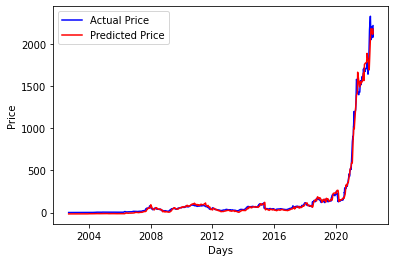

In [17]:
plot_graph(final_df)

In [18]:
final_df.head(20)

,open,high,low,close,adjclose,volume,ticker,adjclose_15,true_adjclose_15,buy_profit,sell_profit
2002-09-10,1.177152,1.177152,1.177152,1.177152,0.036043,0.0,ADANIENT.NS,-16.325665,0.031913,0.0,0.004130
2002-09-12,1.153394,1.176386,1.153394,1.168722,0.035785,504609.0,ADANIENT.NS,-16.327724,0.031538,0.0,0.004247
2002-09-16,1.172554,1.180217,1.157226,1.166423,0.035715,511485.0,ADANIENT.NS,-16.323622,0.032124,0.0,0.003590
2002-09-18,1.153394,1.171787,1.153394,1.161058,0.035550,506044.0,ADANIENT.NS,-16.324625,0.034917,0.0,0.000634
2002-09-19,1.157226,1.164890,1.153394,1.157226,0.035433,485989.0,ADANIENT.NS,-16.327187,0.033908,0.0,0.001525
2002-09-30,1.015447,1.110477,1.015447,1.081355,0.033110,506827.0,ADANIENT.NS,-16.405178,0.034002,0.0,-0.000892
2002-10-01,0.984025,1.072925,0.984025,1.042270,0.031913,517996.0,ADANIENT.NS,-16.427740,0.033955,0.0,-0.002042
2002-10-17,1.121207,1.122739,1.112010,1.115842,0.034166,505365.0,ADANIENT.NS,-16.365538,0.032735,0.0,0.001431
2002-10-24,1.080589,1.088252,1.010849,1.062962,0.032547,623754.0,ADANIENT.NS,-16.372437,0.035996,0.0,-0.003449
2002-10-25,1.049934,1.056831,1.013914,1.033073,0.031632,565910.0,ADANIENT.NS,-16.387758,0.036911,0.0,-0.005280


In [19]:
final_df.tail(20)

,open,high,low,close,adjclose,volume,ticker,adjclose_15,true_adjclose_15,buy_profit,sell_profit
2021-12-02,1692.500000,1735.000000,1687.650024,1732.250000,1731.513916,2159661.0,ADANIENT.NS,1767.939819,1675.487671,-56.026245,0.000000
2021-12-03,1734.000000,1745.000000,1701.099976,1708.099976,1707.374146,1544077.0,ADANIENT.NS,1771.373779,1697.478394,-9.895752,0.000000
2022-01-07,1719.900024,1730.800049,1689.500000,1699.099976,1698.378052,1295933.0,ADANIENT.NS,1784.392212,1714.221191,15.843140,0.000000
2022-01-18,1885.000000,1908.500000,1830.050049,1840.949951,1840.167725,2294146.0,ADANIENT.NS,1890.247192,1782.392334,-57.775391,0.000000
2022-02-09,1724.599976,1791.900024,1718.099976,1783.150024,1782.392334,1674022.0,ADANIENT.NS,1809.836670,1643.101562,-139.290771,0.000000
2022-02-23,1682.000000,1717.500000,1670.000000,1688.699951,1687.982422,1285012.0,ADANIENT.NS,1777.829468,1818.876831,130.894409,0.000000
2022-02-28,1603.750000,1651.099976,1592.250000,1644.449951,1643.751221,1869037.0,ADANIENT.NS,1725.007324,1810.230469,166.479248,0.000000
2022-03-09,1609.599976,1669.949951,1608.000000,1656.550049,1655.846191,1498176.0,ADANIENT.NS,1693.863770,2013.893921,358.047729,0.000000
2022-03-11,1750.000000,1757.000000,1721.199951,1734.099976,1733.363159,1354129.0,ADANIENT.NS,1728.344360,2064.972168,0.000000,-331.609009
2022-03-14,1732.000000,1752.449951,1722.449951,1736.099976,1735.362305,659190.0,ADANIENT.NS,1748.897339,2138.940918,403.578613,0.000000


In [20]:
csv_results_folder = "csv-results"
if not os.path.isdir(csv_results_folder):
    os.mkdir(csv_results_folder)
csv_filename = os.path.join(csv_results_folder, model_name + ".csv")
final_df.to_csv(csv_filename)